**Note: My work is built on the code of Liang et al. Use this link to go to their repository:https://github.com/dawenl/vae_cf**

# Variational autoencoders for collaborative filtering 

This notebook accompanies the paper "*Variational autoencoders for collaborative filtering*" by Dawen Liang, Rahul G. Krishnan, Matthew D. Hoffman, and Tony Jebara, in The Web Conference (aka WWW) 2018.

In this notebook, we will show a complete self-contained example of training a variational autoencoder (as well as a denoising autoencoder) with multinomial likelihood (described in the paper) on the public Movielens-20M dataset, including both data preprocessing and model training.

In [25]:
import os
import shutil
import sys

import numpy as np
from scipy import sparse
from scipy.sparse import vstack

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sn
sn.set()

import pandas as pd

import tensorflow as tf
print(tf.__version__)
from tensorflow.contrib.layers import apply_regularization, l2_regularizer

import bottleneck as bn

1.14.0


## Data preprocessing

We load the data and create train/validation/test splits following strong generalization: 

- We split all users into training/validation/test sets. 

- We train models using the entire click history of the training users. 

- To evaluate, we take part of the click history from held-out (validation and test) users to learn the necessary user-level representations for the model and then compute metrics by looking at how well the model ranks the rest of the unseen click history from the held-out users.

First, download the dataset at http://files.grouplens.org/datasets/movielens/ml-20m.zip

In [26]:
### change `DATA_DIR` to the location where movielens-20m dataset sits
DATA_DIR = './ml-20m/'

In [27]:
raw_data = pd.read_csv(os.path.join(DATA_DIR, 'ratings.csv'), header=0)

In [28]:
raw_data = raw_data[raw_data['rating'] > 3.5]

In [29]:
raw_data.head()

,userId,movieId,rating,timestamp
6,1,151,4.0,1094785734
7,1,223,4.0,1112485573
8,1,253,4.0,1112484940
9,1,260,4.0,1112484826
10,1,293,4.0,1112484703


### Data splitting procedure

- Select 10K users as heldout users, 10K users as validation users, and the rest of the users for training
- Use all the items from the training users as item set
- For each of both validation and test user, subsample 80% as fold-in data and the rest for prediction 

In [30]:
def get_count(tp, id):
    playcount_groupbyid = tp[[id]].groupby(id, as_index=False)
    count = playcount_groupbyid.size()
    return count['size']

In [31]:
def filter_triplets(tp, min_uc=5, min_sc=0):
    # Only keep the triplets for items which were clicked on by at least min_sc users. 
    if min_sc > 0:
        itemcount = get_count(tp, 'movieId')
        tp = tp[tp['movieId'].isin(itemcount.index[itemcount >= min_sc])]
    
    # Only keep the triplets for users who clicked on at least min_uc items
    # After doing this, some of the items will have less than min_uc users, but should only be a small proportion
    if min_uc > 0:
        usercount = get_count(tp, 'userId')
        tp = tp[tp['userId'].isin(usercount.index[usercount >= min_uc])]
    
    # Update both usercount and itemcount after filtering
    usercount, itemcount = get_count(tp, 'userId'), get_count(tp, 'movieId') 
    return tp, usercount, itemcount

Only keep items that are clicked on by at least $min uc$ users

In [32]:
min_uc = 0  #The results reported on: [0, 5, 20, 40, 50]

In [33]:
raw_data, user_activity, item_popularity = filter_triplets(raw_data, min_uc)

In [34]:
sparsity = 1. * raw_data.shape[0] / (user_activity.shape[0] * item_popularity.shape[0])

print("After filtering, there are %d watching events from %d users and %d movies (sparsity: %.3f%%)" % 
      (raw_data.shape[0], user_activity.shape[0], item_popularity.shape[0], sparsity * 100))

After filtering, there are 9995410 watching events from 138287 users and 20720 movies (sparsity: 0.349%)


In [35]:
unique_uid = user_activity.index

np.random.seed(98765)
idx_perm = np.random.permutation(unique_uid.size)
unique_uid = unique_uid[idx_perm]

In [36]:
# create train/validation/test users
n_users = unique_uid.size
n_heldout_users = 10000

tr_users = unique_uid[:(n_users - n_heldout_users * 2)]
tr_users_part = unique_uid[:int((n_users - n_heldout_users * 2)/12)]
vd_users = unique_uid[(n_users - n_heldout_users * 2): (n_users - n_heldout_users)]
te_users = unique_uid[(n_users - n_heldout_users):]

In [37]:
train_plays = raw_data.loc[raw_data['userId'].isin(tr_users)]
train_plays_part = raw_data.loc[raw_data['userId'].isin(tr_users_part)]

In [38]:
unique_sid = pd.unique(train_plays['movieId'])

In [39]:
show2id = dict((sid, i) for (i, sid) in enumerate(unique_sid))
profile2id = dict((pid, i) for (i, pid) in enumerate(unique_uid))

In [40]:
pro_dir = os.path.join(DATA_DIR, 'pro_sg')

if not os.path.exists(pro_dir):
    os.makedirs(pro_dir)

with open(os.path.join(pro_dir, 'unique_sid.txt'), 'w') as f:
    for sid in unique_sid:
        f.write('%s\n' % sid)

In [41]:
def split_train_test_proportion(data, test_prop=0.2):
    data_grouped_by_user = data.groupby('userId')
    tr_list, te_list = list(), list()

    np.random.seed(98765)

    for i, (_, group) in enumerate(data_grouped_by_user):
        n_items_u = len(group)

        if n_items_u >= 5:
            idx = np.zeros(n_items_u, dtype='bool')
            idx[np.random.choice(n_items_u, size=int(test_prop * n_items_u), replace=False).astype('int64')] = True

            tr_list.append(group[np.logical_not(idx)])
            te_list.append(group[idx])
        else:
            tr_list.append(group)

        if i % 1000 == 0:
            print("%d users sampled" % i)
            sys.stdout.flush()

    data_tr = pd.concat(tr_list)
    data_te = pd.concat(te_list)
    
    return data_tr, data_te

In [42]:
vad_plays = raw_data.loc[raw_data['userId'].isin(vd_users)]
vad_plays = vad_plays.loc[vad_plays['movieId'].isin(unique_sid)]

In [43]:
train_plays_tr, train_plays_te = split_train_test_proportion(train_plays_part)

0 users sampled
1000 users sampled
2000 users sampled
3000 users sampled
4000 users sampled
5000 users sampled
6000 users sampled
7000 users sampled
8000 users sampled
9000 users sampled


In [44]:
vad_plays_tr, vad_plays_te = split_train_test_proportion(vad_plays)

0 users sampled
1000 users sampled
2000 users sampled
3000 users sampled
4000 users sampled
5000 users sampled
6000 users sampled
7000 users sampled
8000 users sampled
9000 users sampled


In [45]:
test_plays = raw_data.loc[raw_data['userId'].isin(te_users)]
test_plays = test_plays.loc[test_plays['movieId'].isin(unique_sid)]

In [46]:
test_plays_tr, test_plays_te = split_train_test_proportion(test_plays)

0 users sampled
1000 users sampled
2000 users sampled
3000 users sampled
4000 users sampled
5000 users sampled
6000 users sampled
7000 users sampled
8000 users sampled
9000 users sampled


### Save the data into (user_index, item_index) format

In [47]:
def numerize(tp):
    uid = list(map(lambda x: profile2id[x], tp['userId']))
    sid = list(map(lambda x: show2id[x], tp['movieId']))
    return pd.DataFrame(data={'uid': uid, 'sid': sid}, columns=['uid', 'sid'])

In [48]:
train_data = numerize(train_plays)
train_data.to_csv(os.path.join(pro_dir, 'train.csv'), index=False)

In [49]:
train_data_tr = numerize(train_plays_tr)
train_data_tr.to_csv(os.path.join(pro_dir, 'train_tr.csv'), index=False)

In [50]:
train_data_te = numerize(train_plays_te)
train_data_te.to_csv(os.path.join(pro_dir, 'train_te.csv'), index=False)

In [51]:
vad_data_tr = numerize(vad_plays_tr)
vad_data_tr.to_csv(os.path.join(pro_dir, 'validation_tr.csv'), index=False)

In [52]:
vad_data_te = numerize(vad_plays_te)
vad_data_te.to_csv(os.path.join(pro_dir, 'validation_te.csv'), index=False)

In [53]:
test_data_tr = numerize(test_plays_tr)
test_data_tr.to_csv(os.path.join(pro_dir, 'test_tr.csv'), index=False)

In [54]:
test_data_te = numerize(test_plays_te)
test_data_te.to_csv(os.path.join(pro_dir, 'test_te.csv'), index=False)

## Model definition and training

I define two related models: denoising autoencoder with multinomial likelihood (Multi-DAE in the paper) and partially-regularized variational autoencoder with multinomial likelihood (Multi-VAE^{PR} in the paper). The Multi-VAE^{PR} model is built on the Multi-DAE model as in the paper.

### Model definition

__Notations__: We use $u \in \{1,\dots,U\}$ to index users and $i \in \{1,\dots,I\}$ to index items. In this work, we consider learning with implicit feedback. The user-by-item interaction matrix is the click matrix $\mathbf{X} \in \mathbb{N}^{U\times I}$. The lower case $\mathbf{x}_u =[X_{u1},\dots,X_{uI}]^\top \in \mathbb{N}^I$ is a bag-of-words vector with the number of clicks for each item from user u. We binarize the click matrix. It is straightforward to extend it to general count data.

__Generative process__: For each user $u$, the model starts by sampling a $K$-dimensional latent representation $\mathbf{z}_u$ from a standard Gaussian prior. The latent representation $\mathbf{z}_u$ is transformed via a non-linear function $f_\theta (\cdot) \in \mathbb{R}^I$ to produce a probability distribution over $I$ items $\pi (\mathbf{z}_u)$ from which the click history $\mathbf{x}_u$ is assumed to have been drawn:

$$
\mathbf{z}_u \sim \mathcal{N}(0, \mathbf{I}_K),  \pi(\mathbf{z}_u) \propto \exp\{f_\theta (\mathbf{z}_u\},\\
\mathbf{x}_u \sim \mathrm{Mult}(N_u, \pi(\mathbf{z}_u))
$$

The objective for Multi-DAE for a single user $u$ is:
$$
\mathcal{L}_u(\theta, \phi) = \log p_\theta(\mathbf{x}_u | g_\phi(\mathbf{x}_u))
$$
where $g_\phi(\cdot)$ is the non-linear "encoder" function.

**Note: All formulas and definition are taken from Liang et al. To see the paper, use this link: https://arxiv.org/abs/1802.05814**

In [55]:
class MultiDAE(object):
    #q: encoder, p: decoder
    def __init__(self, p_dims, q_dims=None, lam=0.01, lr=1e-3, random_seed=None):
        self.p_dims = p_dims
        if q_dims is None:
            self.q_dims = p_dims[::-1]
        else:
            assert q_dims[0] == p_dims[-1], "Input and output dimension must equal each other for autoencoders."
            assert q_dims[-1] == p_dims[0], "Latent dimension for p- and q-network mismatches."
            self.q_dims = q_dims
        self.dims = self.q_dims + self.p_dims[1:]
        
        self.lam = lam
        self.lr = lr
        self.random_seed = random_seed

        self.construct_placeholders()

    def construct_placeholders(self):        
        self.input_ph = tf.placeholder(
            dtype=tf.float32, shape=[None, self.dims[0]])
        self.keep_prob_ph = tf.placeholder_with_default(1.0, shape=None)

    def build_graph(self):

        self.construct_weights()

        saver, logits = self.forward_pass()
        log_softmax_var = tf.nn.log_softmax(logits)

        # per-user average negative log-likelihood
        neg_ll = -tf.reduce_mean(tf.reduce_sum(
            log_softmax_var * self.input_ph, axis=1))
        # apply regularization to weights
        reg = l2_regularizer(self.lam)
        reg_var = apply_regularization(reg, self.weights)
        # tensorflow l2 regularization multiply 0.5 to the l2 norm
        # multiply 2 so that it is back in the same scale
        loss = neg_ll + 2 * reg_var
        
        train_op = tf.train.AdamOptimizer(self.lr).minimize(loss)

        # add summary statistics
        tf.summary.scalar('negative_multi_ll', neg_ll)
        tf.summary.scalar('loss', loss)
        merged = tf.summary.merge_all()
        return saver, logits, loss, train_op, merged

    def forward_pass(self):
        # construct forward graph        
        h = tf.nn.l2_normalize(self.input_ph, 1)
        h = tf.nn.dropout(h, self.keep_prob_ph)
        
        for i, (w, b) in enumerate(zip(self.weights, self.biases)):
            h = tf.matmul(h, w) + b
            
            if i != len(self.weights) - 1:
                h = tf.nn.tanh(h)
        return tf.train.Saver(), h

    def construct_weights(self):

        self.weights = []
        self.biases = []
        
        # define weights
        for i, (d_in, d_out) in enumerate(zip(self.dims[:-1], self.dims[1:])):
            weight_key = "weight_{}to{}".format(i, i+1)
            bias_key = "bias_{}".format(i+1)
            
            self.weights.append(tf.get_variable(
                name=weight_key, shape=[d_in, d_out],
                initializer=tf.contrib.layers.xavier_initializer(
                    seed=self.random_seed)))
            
            self.biases.append(tf.get_variable(
                name=bias_key, shape=[d_out],
                initializer=tf.truncated_normal_initializer(
                    stddev=0.001, seed=self.random_seed)))
            
            # add summary stats
            tf.summary.histogram(weight_key, self.weights[-1])
            tf.summary.histogram(bias_key, self.biases[-1])

The objective of Multi-VAE^{PR} (evidence lower-bound, or ELBO) for a single user $u$ is:
$$
\mathcal{L}_u(\theta, \phi) = \mathbb{E}_{q_\phi(z_u | x_u)}[\log p_\theta(x_u | z_u)] - \beta \cdot KL(q_\phi(z_u | x_u) \| p(z_u))
$$
where $q_\phi$ is the approximating variational distribution (inference model). $\beta$ is the additional annealing parameter that we control. The objective of the entire dataset is the average over all the users. It can be trained almost the same as Multi-DAE, thanks to reparametrization trick. 

In [56]:
class MultiVAE(MultiDAE):

    def construct_placeholders(self):
        super(MultiVAE, self).construct_placeholders()

        # placeholders with default values when scoring
        self.is_training_ph = tf.placeholder_with_default(0., shape=None)
        self.anneal_ph = tf.placeholder_with_default(1., shape=None)
        
    def build_graph(self, likelihood_loss_type='logistic'):
        self._construct_weights()

        saver, logits, KL = self.forward_pass()
        log_softmax_var = tf.nn.log_softmax(logits)
        softmax_var = tf.nn.softmax(logits)
        n_log_softmax_var = tf.nn.log_softmax(1-logits)
        
        if likelihood_loss_type=='logistic':
            neg_ll = -tf.reduce_mean(tf.reduce_sum(
                         (self.input_ph * tf.math.log(1 / (1 + tf.exp(-(logits+1e-5))))) + (1-self.input_ph) * tf.math.log(1e-5 + 1-(1 / (1 + tf.exp(-(logits+1e-5))))),
                          axis=-1))
        elif likelihood_loss_type=='multinomial':
            neg_ll = -tf.reduce_mean(tf.reduce_sum(
                        log_softmax_var * self.input_ph,
                        axis=-1))
        elif likelihood_loss_type=='gaussian':
            neg_ll = tf.reduce_mean(tf.reduce_sum(
                (self.input_ph-logits)**2,
                axis=-1))
            
        elif likelihood_loss_type=='bernoulli':
            neg_ll = -tf.reduce_mean(tf.reduce_sum(
                 (log_softmax_var * self.input_ph) + (1-self.input_ph)*n_log_softmax_var,
                 axis=-1))
            
        elif likelihood_loss_type=='poisson':
            neg_ll = -tf.reduce_mean(tf.reduce_sum(
                 (log_softmax_var * self.input_ph)-logits,
                 axis=-1))
            
        elif likelihood_loss_type=='exponential':
            neg_ll = -tf.reduce_mean(tf.reduce_sum(
                 (log_softmax_var * self.input_ph)-log_softmax_var,
                 axis=-1))
            
            
        # apply regularization to weights
        reg = l2_regularizer(self.lam)
        
        reg_var = apply_regularization(reg, self.weights_q + self.weights_p)
        # tensorflow l2 regularization multiply 0.5 to the l2 norm
        # multiply 2 so that it is back in the same scale
        neg_ELBO = neg_ll + self.anneal_ph * KL + 2 * reg_var
        
        train_op = tf.train.AdamOptimizer(self.lr).minimize(neg_ELBO)

        # add summary statistics
        tf.summary.scalar('negative_multi_ll', neg_ll)
        tf.summary.scalar('KL', KL)
        tf.summary.scalar('neg_ELBO_train', neg_ELBO)
        merged = tf.summary.merge_all()

        return saver, logits, neg_ELBO, train_op, merged
    
    def q_graph(self):
        mu_q, std_q, KL = None, None, None
        
        h = tf.nn.l2_normalize(self.input_ph, 1)
        h = tf.nn.dropout(h, self.keep_prob_ph)
        
        for i, (w, b) in enumerate(zip(self.weights_q, self.biases_q)):
            h = tf.matmul(h, w) + b
            
            if i != len(self.weights_q) - 1:
                h = tf.nn.tanh(h)
            else:
                mu_q = h[:, :self.q_dims[-1]]
                logvar_q = h[:, self.q_dims[-1]:]

                std_q = tf.exp(0.5 * logvar_q)
                KL = tf.reduce_mean(tf.reduce_sum(
                        0.5 * (-logvar_q + tf.exp(logvar_q) + mu_q**2 - 1), axis=1))
        return mu_q, std_q, KL

    def p_graph(self, z):
        h = z
        
        for i, (w, b) in enumerate(zip(self.weights_p, self.biases_p)):
            h = tf.matmul(h, w) + b
            
            if i != len(self.weights_p) - 1:
                h = tf.nn.tanh(h)
        return h

    def forward_pass(self):
        # q-network
        mu_q, std_q, KL = self.q_graph()
        epsilon = tf.random_normal(tf.shape(std_q))

        sampled_z = mu_q + self.is_training_ph *\
            epsilon * std_q

        # p-network
        logits = self.p_graph(sampled_z)
        
        return tf.train.Saver(), logits, KL

    def _construct_weights(self):
        self.weights_q, self.biases_q = [], []
        
        for i, (d_in, d_out) in enumerate(zip(self.q_dims[:-1], self.q_dims[1:])):
            if i == len(self.q_dims[:-1]) - 1:
                # we need two sets of parameters for mean and variance,
                # respectively
                d_out *= 2
            weight_key = "weight_q_{}to{}".format(i, i+1)
            bias_key = "bias_q_{}".format(i+1)
            
            self.weights_q.append(tf.get_variable(
                name=weight_key, shape=[d_in, d_out],
                initializer=tf.contrib.layers.xavier_initializer(
                    seed=self.random_seed)))
            
            self.biases_q.append(tf.get_variable(
                name=bias_key, shape=[d_out],
                initializer=tf.truncated_normal_initializer(
                    stddev=0.001, seed=self.random_seed)))
            
            # add summary stats
            tf.summary.histogram(weight_key, self.weights_q[-1])
            tf.summary.histogram(bias_key, self.biases_q[-1])
            
        self.weights_p, self.biases_p = [], []

        for i, (d_in, d_out) in enumerate(zip(self.p_dims[:-1], self.p_dims[1:])):
            weight_key = "weight_p_{}to{}".format(i, i+1)
            bias_key = "bias_p_{}".format(i+1)
            self.weights_p.append(tf.get_variable(
                name=weight_key, shape=[d_in, d_out],
                initializer=tf.contrib.layers.xavier_initializer(
                    seed=self.random_seed)))
            
            self.biases_p.append(tf.get_variable(
                name=bias_key, shape=[d_out],
                initializer=tf.truncated_normal_initializer(
                    stddev=0.001, seed=self.random_seed)))
            
            # add summary stats
            tf.summary.histogram(weight_key, self.weights_p[-1])
            tf.summary.histogram(bias_key, self.biases_p[-1])

### Training/validation data, hyperparameters

Load the pre-processed training and validation data

In [57]:
DATA_DIR = './ml-20m/'
pro_dir = os.path.join(DATA_DIR, 'pro_sg')
unique_sid = list()
with open(os.path.join(pro_dir, 'unique_sid.txt'), 'r') as f:
    for line in f:
        unique_sid.append(line.strip())

n_items = len(unique_sid)

In [58]:
def load_train_data(csv_file):
    tp = pd.read_csv(csv_file)
    n_users = tp['uid'].max() + 1

    rows, cols = tp['uid'], tp['sid']
    data = sparse.csr_matrix((np.ones_like(rows),
                             (rows, cols)), dtype='float64',
                             shape=(n_users, n_items))
    return data

In [59]:
train_data = load_train_data(os.path.join(pro_dir, 'train.csv'))

In [60]:
def load_tr_te_data(csv_file_tr, csv_file_te):
    tp_tr = pd.read_csv(csv_file_tr)
    tp_te = pd.read_csv(csv_file_te)

    start_idx = min(tp_tr['uid'].min(), tp_te['uid'].min())
    end_idx = max(tp_tr['uid'].max(), tp_te['uid'].max())

    rows_tr, cols_tr = tp_tr['uid'] - start_idx, tp_tr['sid']
    rows_te, cols_te = tp_te['uid'] - start_idx, tp_te['sid']

    data_tr = sparse.csr_matrix((np.ones_like(rows_tr),
                             (rows_tr, cols_tr)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))
    data_te = sparse.csr_matrix((np.ones_like(rows_te),
                             (rows_te, cols_te)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))
    return data_tr, data_te

In [61]:
vad_data_tr, vad_data_te = load_tr_te_data(os.path.join(pro_dir, 'validation_tr.csv'),
                                           os.path.join(pro_dir, 'validation_te.csv'))

test_data_tr, test_data_te = load_tr_te_data(os.path.join(pro_dir, 'test_tr.csv'),
                                           os.path.join(pro_dir, 'test_te.csv'))

train_data_tr, train_data_te = load_tr_te_data(os.path.join(pro_dir, 'train_tr.csv'),
                                           os.path.join(pro_dir, 'train_te.csv'))

Set up training hyperparameters

In [62]:
N = train_data.shape[0]
idxlist = list(range(N))

N_train = train_data_tr.shape[0]
idxlist_train = list(range(N_train))
N_vad = vad_data_tr.shape[0]
idxlist_vad = list(range(N_vad))

# training batch size
batch_size = 500
batches_per_epoch = int(np.ceil(float(N) / batch_size))

# validation batch size (since the entire validation set might not fit into GPU memory)
batch_size_vad = 2000

# the total number of gradient updates for annealing
total_anneal_steps = 200000
# largest annealing parameter
anneal_cap = 0.2

Evaluate function: Normalized discounted cumulative gain (NDCG@k) and Recall@k

In [63]:
def NDCG_binary_at_k_batch(X_pred, heldout_batch, k=100):
    '''
    normalized discounted cumulative gain@k for binary relevance
    ASSUMPTIONS: all the 0's in heldout_data indicate 0 relevance
    '''
    batch_users = X_pred.shape[0]
    idx_topk_part = bn.argpartition(-X_pred, k, axis=1)
    topk_part = X_pred[np.arange(batch_users)[:, np.newaxis],
                       idx_topk_part[:, :k]]
    idx_part = np.argsort(-topk_part, axis=1)
    # X_pred[np.arange(batch_users)[:, np.newaxis], idx_topk] is the sorted
    # topk predicted score
    idx_topk = idx_topk_part[np.arange(batch_users)[:, np.newaxis], idx_part]
    # build the discount template
    tp = 1. / np.log2(np.arange(2, k + 2))

    DCG = (heldout_batch[np.arange(batch_users)[:, np.newaxis],
                         idx_topk].toarray() * tp).sum(axis=1)
    IDCG = np.array([(tp[:min(n, k)]).sum()
                     for n in heldout_batch.getnnz(axis=1)])
    return DCG / (IDCG + 0.0001)

In [64]:
def Recall_at_k_batch(X_pred, heldout_batch, k=100):
    batch_users = X_pred.shape[0]

    idx = bn.argpartition(-X_pred, k, axis=1)
    X_pred_binary = np.zeros_like(X_pred, dtype=bool)
    X_pred_binary[np.arange(batch_users)[:, np.newaxis], idx[:, :k]] = True

    X_true_binary = (heldout_batch > 0).toarray()
    tmp = (np.logical_and(X_true_binary, X_pred_binary).sum(axis=1)).astype(
        np.float32)
    recall = tmp / (np.minimum(k, X_true_binary.sum(axis=1)) + 0.0001)
    return recall

### Train a Multi-VAE^{PR}

For ML-20M dataset, we set both the generative function $f_\theta(\cdot)$ and the inference model $g_\phi(\cdot)$ to be 3-layer multilayer perceptron (MLP) with symmetrical architecture. 

The generative function is a [200 -> 600 -> n_items] MLP, which means the inference function is a [n_items -> 600 -> 200] MLP. Thus the overall architecture for the Multi-VAE^{PR} is [n_items -> 600 -> 200 -> 600 -> n_items].

In [65]:
p_dims = [200, 600, n_items]

In [67]:
tf.reset_default_graph()
vae = MultiVAE(p_dims, lam=0.0, random_seed=98765)

#Available likelihood loss types are: ['logistic', 'multinomial', 'gaussian', 'bernoulli', 'exponential', 'poisson']
likelihood_loss_type = 'logistic'
saver, logits_var, loss_var, train_op_var, merged_var = vae.build_graph(likelihood_loss_type)

ndcg_var = tf.Variable(0.0)
ndcg_dist_var = tf.placeholder(dtype=tf.float64, shape=None)
ndcg_summary = tf.summary.scalar('ndcg_at_k_validation', ndcg_var)
ndcg_dist_summary = tf.summary.histogram('ndcg_at_k_hist_validation', ndcg_dist_var)
merged_valid = tf.summary.merge([ndcg_summary, ndcg_dist_summary])

INFO:tensorflow:Scale of 0 disables regularizer.


Set up logging and checkpoint directory

- Change all the logging directory and checkpoint directory to somewhere of your choice
- Monitor training progress using tensorflow by: `tensorboard --logdir=$log_dir`

In [74]:
arch_str = "I-%s-I" % ('-'.join([str(d) for d in vae.dims[1:-1]]))

In [75]:
log_dir = './ml-20m/log/VAE_anneal{}K_cap{:1.1E}/{}'.format(
    total_anneal_steps/1000, anneal_cap, arch_str)

if os.path.exists(log_dir):
    shutil.rmtree(log_dir)

print("log directory: %s" % log_dir)
summary_writer = tf.summary.FileWriter(log_dir, graph=tf.get_default_graph())

log directory: ./ml-20m/log/VAE_anneal200.0K_cap2.0E-01/I-600-200-600-I


In [76]:
chkpt_dir = './ml-20m/VAE_anneal{}K_cap{:1.1E}/{}'.format(
    total_anneal_steps/1000, anneal_cap, arch_str)

if not os.path.isdir(chkpt_dir):
    os.makedirs(chkpt_dir) 
    
print("chkpt directory: %s" % chkpt_dir)

chkpt directory: ./ml-20m/VAE_anneal200.0K_cap2.0E-01/I-600-200-600-I


In [77]:
n_epochs = 200

In [78]:
ndcgs_vad = []
ndcgs_train = []

with tf.Session() as sess:

    init = tf.global_variables_initializer()
    sess.run(init)

    best_ndcg = -np.inf

    update_count = 0.0
    
    for epoch in range(n_epochs):
        print('EPOCH: ', epoch)
        np.random.shuffle(idxlist)
        for bnum, st_idx in enumerate(range(0, N, batch_size)):
            end_idx = min(st_idx + batch_size, N)
            X = train_data[idxlist[st_idx:end_idx]]
            
            if sparse.isspmatrix(X):
                X = X.toarray()
            X = X.astype('float32')           
            
            if total_anneal_steps > 0:
                anneal = min(anneal_cap, 1. * update_count / total_anneal_steps)
            else:
                anneal = anneal_cap
            
            feed_dict = {vae.input_ph: X, 
                         vae.keep_prob_ph: 0.5, 
                         vae.anneal_ph: anneal,
                         vae.is_training_ph: 1}        
            sess.run(train_op_var, feed_dict=feed_dict)

            if bnum % 100 == 0:
                summary_train = sess.run(merged_var, feed_dict=feed_dict)
                summary_writer.add_summary(summary_train, 
                                           global_step=epoch * batches_per_epoch + bnum) 
            
            
            update_count += 1
            
        
        # compute train NDCG 
        ndcg_dist_train = []
        for bnum, st_idx in enumerate(range(0, N_train, batch_size_vad)):
            end_idx = min(st_idx + batch_size_vad, N_train)
            X = train_data_tr[idxlist_train[st_idx:end_idx]]


            if sparse.isspmatrix(X):
                X = X.toarray()
            X = X.astype('float32')
        
            pred_train = sess.run(logits_var, feed_dict={vae.input_ph: X} )
            # exclude examples from training and validation (if any)
            pred_train[X.nonzero()] = -np.inf
            ndcg_dist_train.append(NDCG_binary_at_k_batch(pred_train, train_data_te[idxlist_train[st_idx:end_idx]]))
        
        ndcg_dist_train = np.concatenate(ndcg_dist_train)
        ndcg_train_ = ndcg_dist_train.mean()
        ndcgs_train.append(ndcg_train_)
        
        # compute validation NDCG
        ndcg_dist = []
        for bnum, st_idx in enumerate(range(0, N_vad, batch_size_vad)):
            end_idx = min(st_idx + batch_size_vad, N_vad)
            X = vad_data_tr[idxlist_vad[st_idx:end_idx]]

            if sparse.isspmatrix(X):
                X = X.toarray()
            X = X.astype('float32')
        
            pred_val = sess.run(logits_var, feed_dict={vae.input_ph: X} )
            # exclude examples from training and validation (if any)
            pred_val[X.nonzero()] = -np.inf
            ndcg_dist.append(NDCG_binary_at_k_batch(pred_val, vad_data_te[idxlist_vad[st_idx:end_idx]]))
        
        ndcg_dist = np.concatenate(ndcg_dist)
        ndcg_ = ndcg_dist.mean()
        ndcgs_vad.append(ndcg_)
        merged_valid_val = sess.run(merged_valid, feed_dict={ndcg_var: ndcg_, ndcg_dist_var: ndcg_dist})
        summary_writer.add_summary(merged_valid_val, epoch)

        # update the best model (if necessary)
        if ndcg_ > best_ndcg:
            saver.save(sess, '{}_{}_epochs{}_minuc{}/model'.format(chkpt_dir, likelihood_loss_type, n_epochs, min_uc))
            best_ndcg = ndcg_

EPOCH:  0
EPOCH:  1
EPOCH:  2
EPOCH:  3
EPOCH:  4
EPOCH:  5
EPOCH:  6
EPOCH:  7
EPOCH:  8
EPOCH:  9
EPOCH:  10
EPOCH:  11
EPOCH:  12
EPOCH:  13
EPOCH:  14
EPOCH:  15
EPOCH:  16
EPOCH:  17
EPOCH:  18
EPOCH:  19
EPOCH:  20
EPOCH:  21
EPOCH:  22
EPOCH:  23
EPOCH:  24
EPOCH:  25
EPOCH:  26
EPOCH:  27
EPOCH:  28
EPOCH:  29
EPOCH:  30
EPOCH:  31
EPOCH:  32
EPOCH:  33
EPOCH:  34
EPOCH:  35
EPOCH:  36
EPOCH:  37
EPOCH:  38
EPOCH:  39
EPOCH:  40
EPOCH:  41
EPOCH:  42
EPOCH:  43
EPOCH:  44
EPOCH:  45
EPOCH:  46
EPOCH:  47
EPOCH:  48
EPOCH:  49
EPOCH:  50
EPOCH:  51
EPOCH:  52
EPOCH:  53
EPOCH:  54
EPOCH:  55
EPOCH:  56
EPOCH:  57
EPOCH:  58
EPOCH:  59
EPOCH:  60
EPOCH:  61
EPOCH:  62
EPOCH:  63
EPOCH:  64
EPOCH:  65
EPOCH:  66
EPOCH:  67
EPOCH:  68
EPOCH:  69
EPOCH:  70
EPOCH:  71
EPOCH:  72
EPOCH:  73
EPOCH:  74
EPOCH:  75
EPOCH:  76
EPOCH:  77
EPOCH:  78
EPOCH:  79
EPOCH:  80
EPOCH:  81
EPOCH:  82
EPOCH:  83
EPOCH:  84
EPOCH:  85
EPOCH:  86
EPOCH:  87
EPOCH:  88
EPOCH:  89
EPOCH:  90
EPOCH:  9

Text(0.5, 1.0, 'train vs val for likelihood=logistic and minuc=0 ')

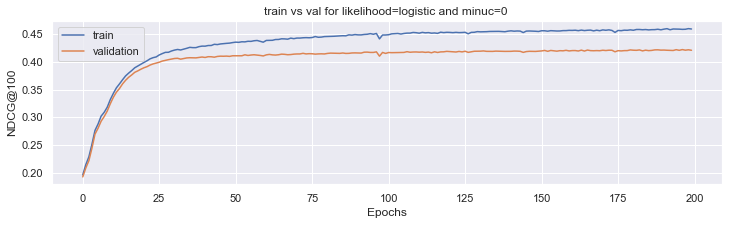

In [79]:
plt.figure(figsize=(12, 3))
plt.plot(ndcgs_train, label='train')
plt.plot(ndcgs_vad, label='validation')
plt.legend()
plt.ylabel("NDCG@100")
plt.xlabel("Epochs")
plt.title("train vs val for likelihood={} and minuc={} ".format(likelihood_loss_type,min_uc))

In [80]:
np.savetxt('results/NDCG_train_' + likelihood_loss_type +'_epochs' + str(n_epochs) + '_minuc' + str(min_uc) + '.csv', ndcgs_train, delimiter=",")
np.savetxt('results/NDCG_val_' + likelihood_loss_type +'_epochs' + str(n_epochs) + '_minuc' + str(min_uc) + '.csv', ndcgs_vad, delimiter=",")

## Plot Results

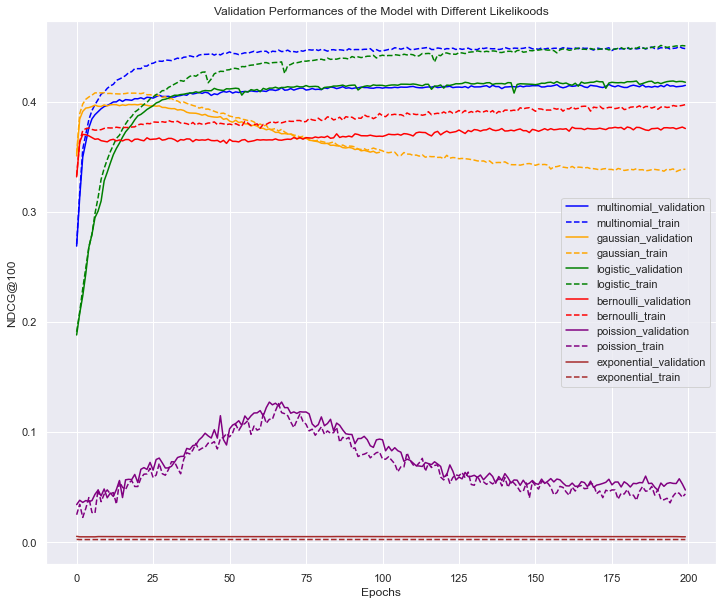

In [81]:
multinomial_result_val = np.loadtxt("results/NDCG_val_multinomial_epochs200_minuc5.csv", delimiter=",")
multinomial_result_train = np.loadtxt("results/NDCG_train_multinomial_epochs200_minuc5.csv", delimiter=",")
gaussian_result_val = np.loadtxt("results/NDCG_val_gaussian_epochs100_minuc5.csv", delimiter=",")
gaussian_result_train = np.loadtxt("results/NDCG_train_gaussian_epochs200_minuc5.csv", delimiter=",")
logistic_result_val = np.loadtxt("results/NDCG_val_logistic_epochs200_minuc5.csv", delimiter=",")
logistic_result_train = np.loadtxt("results/NDCG_train_logistic_epochs200_minuc5.csv", delimiter=",")
bernoulli_result_val = np.loadtxt("results/NDCG_val_bernoulli_epochs200_minuc5.csv", delimiter=",")
bernoulli_result_train = np.loadtxt("results/NDCG_train_bernoulli_epochs200_minuc5.csv", delimiter=",")
poission_result_val = np.loadtxt("results/NDCG_val_poisson_epochs200_minuc5.csv", delimiter=",")
poission_result_train = np.loadtxt("results/NDCG_train_poisson_epochs200_minuc5.csv", delimiter=",")
exponential_result_val = np.loadtxt("results/NDCG_val_exponential_epochs200_minuc5.csv", delimiter=",")
exponential_result_train = np.loadtxt("results/NDCG_train_exponential_epochs200_minuc5.csv", delimiter=",")


plt.figure(figsize=(12, 10))
plt.plot(multinomial_result_val,color="blue",label="multinomial_validation")
plt.plot(multinomial_result_train,color="blue", linestyle='dashed', label="multinomial_train")
                                   
plt.plot(gaussian_result_val,color="orange",label="gaussian_validation")
plt.plot(gaussian_result_train,color="orange", linestyle='dashed', label="gaussian_train")
                                   
plt.plot(logistic_result_val,color="green",label="logistic_validation")
plt.plot(logistic_result_train,color="green", linestyle='dashed', label="logistic_train") 
                                   
plt.plot(bernoulli_result_val,color="red",label="bernoulli_validation")
plt.plot(bernoulli_result_train,color="red", linestyle='dashed', label="bernoulli_train")
                                   
plt.plot(poission_result_val,color="purple",label="poission_validation")
plt.plot(poission_result_train,color="purple", linestyle='dashed', label="poission_train")
                                   
plt.plot(exponential_result_val,color="brown",label="exponential_validation")
plt.plot(exponential_result_train,color="brown", linestyle='dashed', label="exponential_train")
                                   
plt.ylabel("NDCG@100")
plt.xlabel("Epochs")
plt.title("Validation Performances of the Model with Different Likelikoods")
plt.legend()

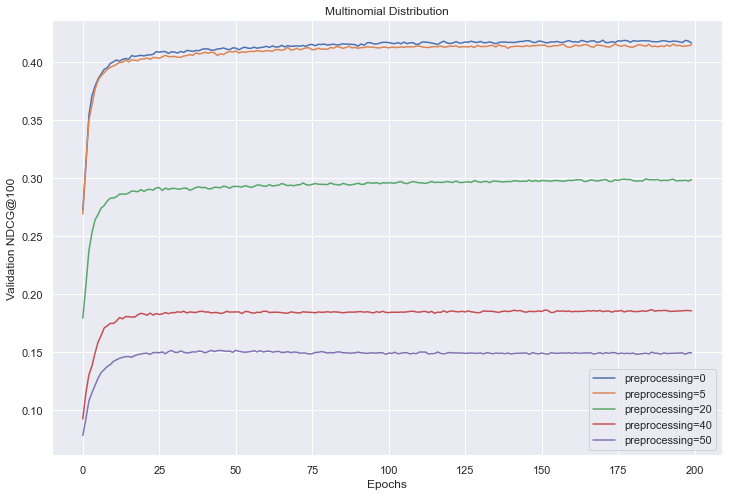

In [82]:
multinomial_val_result_0 = np.loadtxt('results/NDCG_val_multinomial_epochs200_minuc0.csv', delimiter=",")
multinomial_val_result_5 = np.loadtxt('results/NDCG_val_multinomial_epochs200_minuc5.csv', delimiter=",")
multinomial_val_result_20 = np.loadtxt('results/NDCG_val_multinomial_epochs200_minuc20.csv', delimiter=",")
multinomial_val_result_40 = np.loadtxt('results/NDCG_val_multinomial_epochs200_minuc40.csv', delimiter=",")
multinomial_val_result_50 = np.loadtxt('results/NDCG_val_multinomial_epochs200_minuc50.csv', delimiter=",")

plt.figure(figsize=(12, 8))
plt.plot(multinomial_val_result_0,label="preprocessing=0")
plt.plot(multinomial_val_result_5,label="preprocessing=5")
plt.plot(multinomial_val_result_20,label="preprocessing=20")
plt.plot(multinomial_val_result_40,label="preprocessing=40")
plt.plot(multinomial_val_result_50,label="preprocessing=50")

plt.ylabel("Validation NDCG@100")
plt.xlabel("Epochs")
plt.title("Multinomial Distribution")
plt.legend()


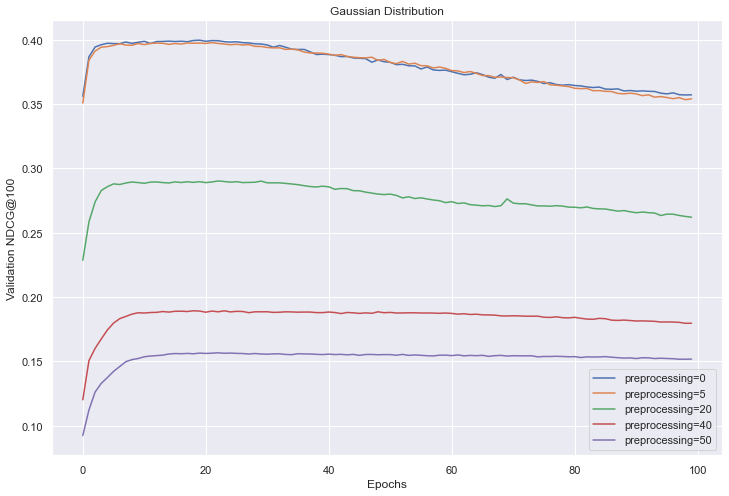

In [83]:
gaussian_val_result_0 = np.loadtxt('results/NDCG_val_gaussian_epochs100_minuc0.csv', delimiter=",")
gaussian_val_result_5 = np.loadtxt('results/NDCG_val_gaussian_epochs100_minuc5.csv', delimiter=",")
gaussian_val_result_20 = np.loadtxt('results/NDCG_val_gaussian_epochs100_minuc20.csv', delimiter=",")
gaussian_val_result_40 = np.loadtxt('results/NDCG_val_gaussian_epochs100_minuc40.csv', delimiter=",")
gaussian_val_result_50 = np.loadtxt('results/NDCG_val_gaussian_epochs100_minuc50.csv', delimiter=",")

plt.figure(figsize=(12, 8))
plt.plot(gaussian_val_result_0,label="preprocessing=0")
plt.plot(gaussian_val_result_5,label="preprocessing=5")
plt.plot(gaussian_val_result_20,label="preprocessing=20")
plt.plot(gaussian_val_result_40,label="preprocessing=40")
plt.plot(gaussian_val_result_50,label="preprocessing=50")

plt.ylabel("Validation NDCG@100")
plt.xlabel("Epochs")
plt.title("Gaussian Distribution")
plt.legend()


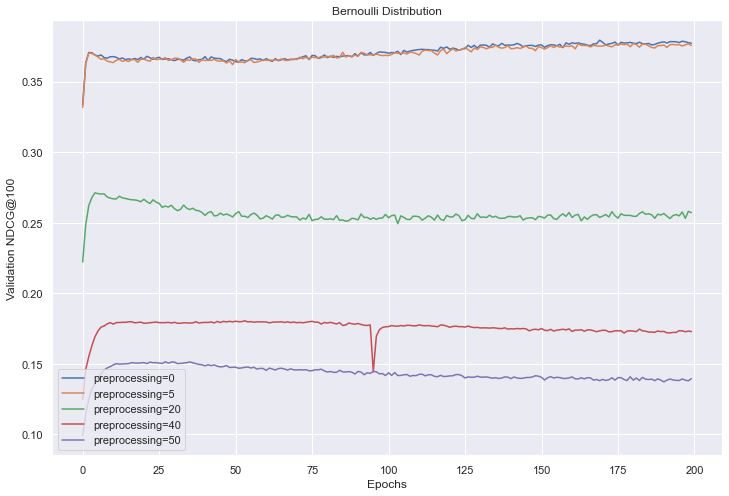

In [84]:
bernoulli_val_result_0 = np.loadtxt('results/NDCG_val_bernoulli_epochs200_minuc0.csv', delimiter=",")
bernoulli_val_result_5 = np.loadtxt('results/NDCG_val_bernoulli_epochs200_minuc5.csv', delimiter=",")
bernoulli_val_result_20 = np.loadtxt('results/NDCG_val_bernoulli_epochs200_minuc20.csv', delimiter=",")
bernoulli_val_result_40 = np.loadtxt('results/NDCG_val_bernoulli_epochs200_minuc40.csv', delimiter=",")
bernoulli_val_result_50 = np.loadtxt('results/NDCG_val_bernoulli_epochs200_minuc50.csv', delimiter=",")

plt.figure(figsize=(12, 8))
plt.plot(bernoulli_val_result_0,label="preprocessing=0")
plt.plot(bernoulli_val_result_5,label="preprocessing=5")
plt.plot(bernoulli_val_result_20,label="preprocessing=20")
plt.plot(bernoulli_val_result_40,label="preprocessing=40")
plt.plot(bernoulli_val_result_50,label="preprocessing=50")

plt.ylabel("Validation NDCG@100")
plt.xlabel("Epochs")
plt.title("Bernoulli Distribution")
plt.legend()


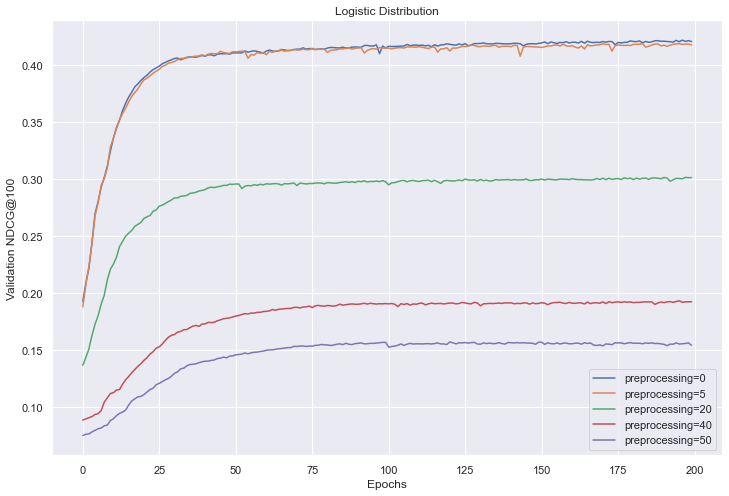

In [85]:
logistic_val_result_0 = np.loadtxt('results/NDCG_val_logistic_epochs200_minuc0.csv', delimiter=",")
logistic_val_result_5 = np.loadtxt('results/NDCG_val_logistic_epochs200_minuc5.csv', delimiter=",")
logistic_val_result_20 = np.loadtxt('results/NDCG_val_logistic_epochs200_minuc20.csv', delimiter=",")
logistic_val_result_40 = np.loadtxt('results/NDCG_val_logistic_epochs200_minuc40.csv', delimiter=",")
logistic_val_result_50 = np.loadtxt('results/NDCG_val_logistic_epochs200_minuc50.csv', delimiter=",")

plt.figure(figsize=(12, 8))
plt.plot(logistic_val_result_0,label="preprocessing=0")
plt.plot(logistic_val_result_5,label="preprocessing=5")
plt.plot(logistic_val_result_20,label="preprocessing=20")
plt.plot(logistic_val_result_40,label="preprocessing=40")
plt.plot(logistic_val_result_50,label="preprocessing=50")

plt.ylabel("Validation NDCG@100")
plt.xlabel("Epochs")
plt.title("Logistic Distribution")
plt.legend()

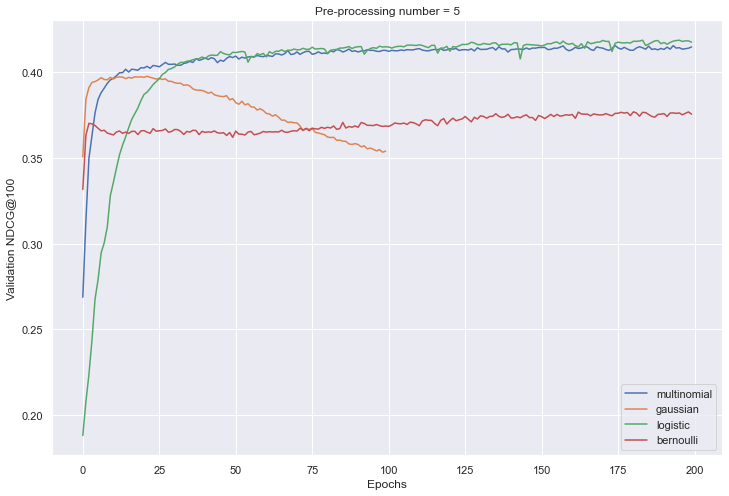

In [86]:
#change minuc at the end of csv to produce other results for corresponding minuc. 
multinomial_val_result = np.loadtxt('results/NDCG_val_multinomial_epochs200_minuc5.csv', delimiter=",")
gaussian_val_result = np.loadtxt('results/NDCG_val_gaussian_epochs100_minuc5.csv', delimiter=",")
logistic_val_result  = np.loadtxt('results/NDCG_val_logistic_epochs200_minuc5.csv', delimiter=",")
bernoulli_val_result  = np.loadtxt('results/NDCG_val_bernoulli_epochs200_minuc5.csv', delimiter=",")


plt.figure(figsize=(12, 8))
plt.plot(multinomial_val_result,label="multinomial")
plt.plot(gaussian_val_result,label="gaussian")
plt.plot(logistic_val_result,label="logistic")
plt.plot(bernoulli_val_result,label="bernoulli")
plt.ylabel("Validation NDCG@100")
plt.xlabel("Epochs")
plt.title("Pre-processing number = 5")
plt.legend()

### Load the test data and compute test metrics

In [87]:
test_data_tr, test_data_te = load_tr_te_data(
    os.path.join(pro_dir, 'test_tr.csv'),
    os.path.join(pro_dir, 'test_te.csv'))

In [88]:
N_test = test_data_tr.shape[0]
idxlist_test = range(N_test)
batch_size_test = 2000

In [89]:
tf.reset_default_graph()
vae = MultiVAE(p_dims, lam=0.0)
saver, logits_var, _, _, _ = vae.build_graph()    

INFO:tensorflow:Scale of 0 disables regularizer.


Load the best performing model on the validation set

In [90]:
chkpt_dir = './ml-20m/VAE_anneal{}K_cap{:1.1E}/{}_{}_epochs{}_minuc{}'.format( #change model name
    total_anneal_steps/1000, anneal_cap, arch_str, likelihood_loss_type, n_epochs, min_uc)
print("chkpt directory: %s" % chkpt_dir)

chkpt directory: ./ml-20m/VAE_anneal200.0K_cap2.0E-01/I-600-200-600-I_logistic_epochs200_minuc0


In [93]:
n100_list, r20_list, r50_list = [], [], []

with tf.Session() as sess:
    saver.restore(sess, '{}/model'.format(chkpt_dir))

    for bnum, st_idx in enumerate(range(0, N_test, batch_size_test)):
        end_idx = min(st_idx + batch_size_test, N_test)
        X = test_data_tr[idxlist_test[st_idx:end_idx]]

        if sparse.isspmatrix(X):
            X = X.toarray()
        X = X.astype('float32')

        pred_val = sess.run(logits_var, feed_dict={vae.input_ph: X})
        # exclude examples from training and validation (if any)
        pred_val[X.nonzero()] = -np.inf
#         print(pred_val)
        n100_list.append(NDCG_binary_at_k_batch(pred_val, test_data_te[idxlist_test[st_idx:end_idx]], k=100))
        r20_list.append(Recall_at_k_batch(pred_val, test_data_te[idxlist_test[st_idx:end_idx]], k=20))
        r50_list.append(Recall_at_k_batch(pred_val, test_data_te[idxlist_test[st_idx:end_idx]], k=50))
    
n100_list = np.concatenate(n100_list)
r20_list = np.concatenate(r20_list)
r50_list = np.concatenate(r50_list)

INFO:tensorflow:Restoring parameters from ./ml-20m/VAE_anneal200.0K_cap2.0E-01/I-600-200-600-I_logistic_epochs200_minuc0/model


In [92]:
print("Test NDCG@100=%.5f (%.5f)" % (np.mean(n100_list), np.std(n100_list) / np.sqrt(len(n100_list))))
print("Test Recall@20=%.5f (%.5f)" % (np.mean(r20_list), np.std(r20_list) / np.sqrt(len(r20_list))))
print("Test Recall@50=%.5f (%.5f)" % (np.mean(r50_list), np.std(r50_list) / np.sqrt(len(r50_list))))

Test NDCG@100=0.42318 (0.00215)
Test Recall@20=0.39350 (0.00273)
Test Recall@50=0.52778 (0.00285)


Since there is randomness the test results can change by approximately 0.002.